In [1]:
from forward_solver import SteadyHeatForwardSolver2D

## Define domain


In [2]:
nmesh=64
mesh_type='quadrilateral'

## Define thermal conductivity

In [3]:
# spatially-varying thermal conductivity
def h_func(x):
    return 1.0 + 6.0*x[0]**2 + 1.0*x[0]/(1.0 + 2.0*x[1]**2)
    #return 1.0

## Define heat source

In [4]:
q=1.0 # constant heat source

## Define boundary condition

In [5]:
T_bottom=300. # in Kelvin, Dirichlet boundary condition on the bottom

## Initialize solver

Not all solvers are equal. Test different solvers and their settings. PETSc KSP Documentation: https://petsc.org/main/manual/ksp/

In [13]:
# Direct method, O(NlogN) memory scaling
## Any matrix decomposition
## Slow
# petsc_options={
#     "ksp_type": "preonly",
#     "pc_type": "lu", 
#     "pc_factor_mat_solver_type": "mumps",
# }
## SPD matrix decompositon, SPD ensured by h(x,y)>0
## Fast
# petsc_options = {
#     "ksp_type": "preonly",
#     "pc_type": "cholesky",
#     "pc_factor_mat_solver_type": "cholmod",
#     "mat_cholmod_factor": "simplicial"
# }
# [DEFAULT] Iterative method - algebraic multigrid (BoomerAMG), O(N) memory scaling
## Fast
petsc_options = {
     'ksp_type': 'cg',
     'pc_type': 'hypre',
     'ksp_rtol': 1e-8,
}

In [14]:
blackbox_solver=SteadyHeatForwardSolver2D(nmesh=nmesh, mesh_type=mesh_type, \
                                          h=h_func, q=q,\
                                          DBC_value=T_bottom,
                                          petsc_opts=petsc_options)

## Solve

In [15]:
%timeit T = blackbox_solver.solve()

6.41 ms ± 221 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Visualize output $T(x,y)$

Plotting relative temperature distribution DeltaT =T-T_0 with T_0=300.0K.


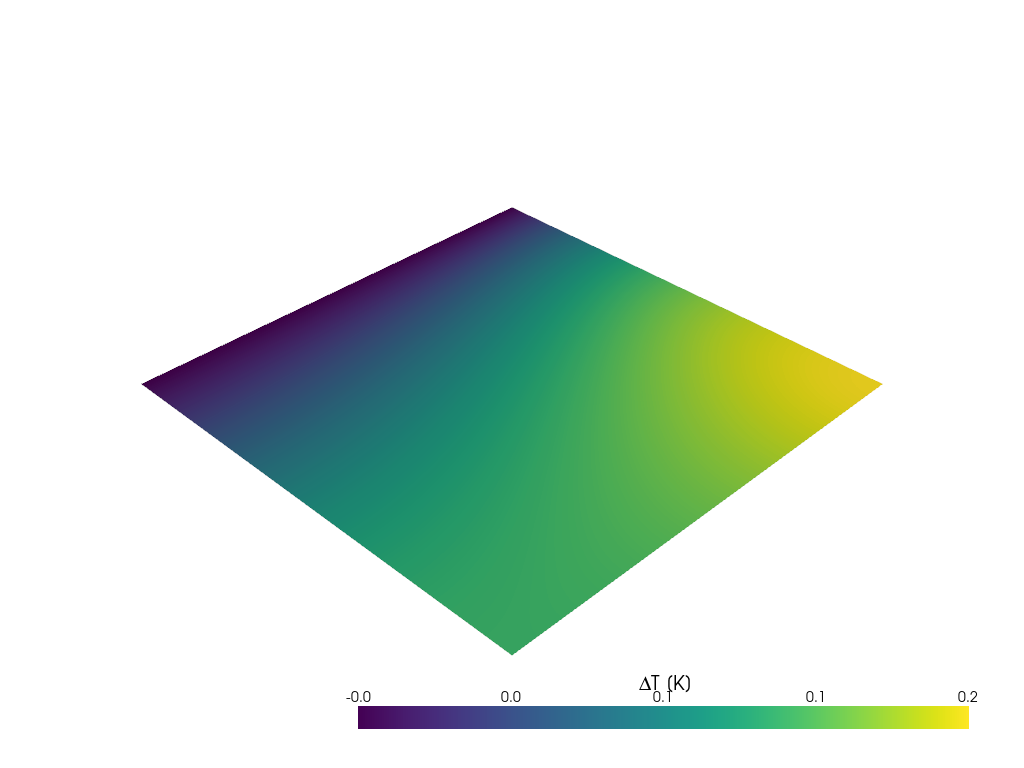

In [9]:
pl = blackbox_solver.plot_output_temperature(T_bottom)
pl.camera_position = 'yx'

In [10]:
T_obs = blackbox_solver.add_noise(0.,1e-2)

Plotting relative temperature distribution DeltaT =T-T_0 with T_0=300.0K.


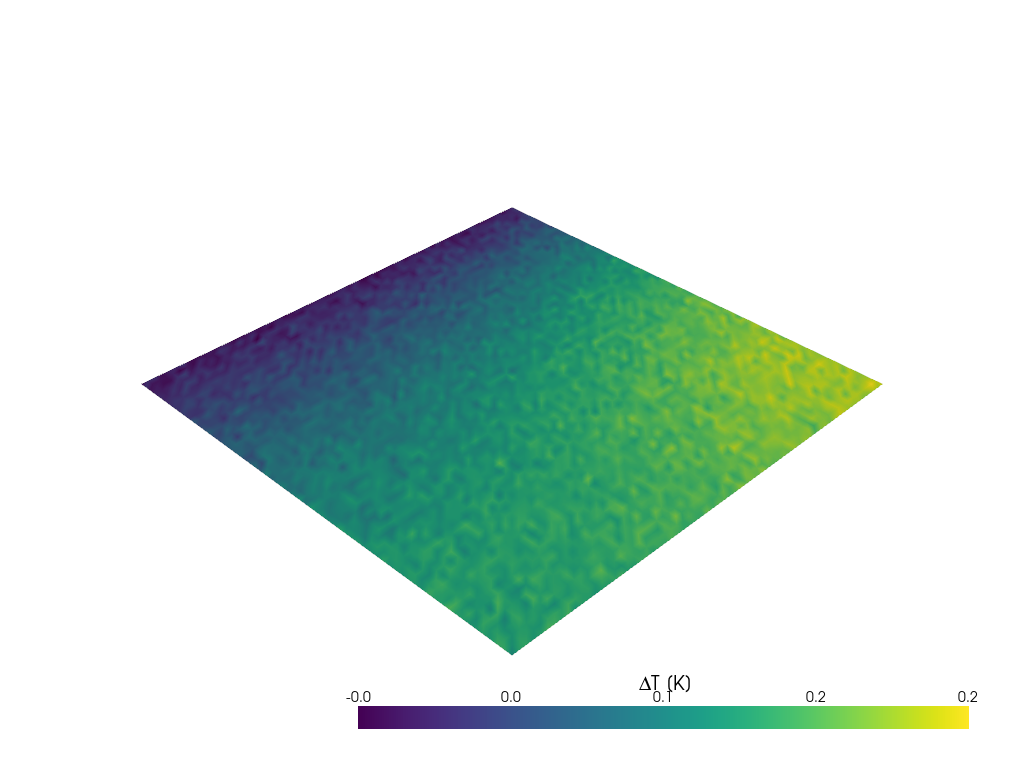

In [12]:
pl = blackbox_solver.plot_output_temperature(T_bottom,noiseless=False)
pl.camera_position = 'yx'

## Save output to disk

In [13]:
import os
test_dir='../test/'
test_outfile_name='blackbox_output'
test_outfile_format='.xdmf'
blackbox_solver.export_xdmf(os.path.join(test_dir,test_outfile_name+test_outfile_format))

## Load saved output from disk

In [14]:
import h5py as h5

def list_h5(name, obj):
    """
    HDF5 IO helper
    """
    if isinstance(obj, h5.Dataset):
        print(f"{name}    Dataset, shape={obj.shape}, dtype={obj.dtype}")
    else:
        print(f"{name}    Group")

test_outfile_format='.h5'
with h5.File(os.path.join(test_dir,test_outfile_name+test_outfile_format), 'r') as f:
    f.visititems(list_h5)

Function    Group
Function/HeatSource    Group
Function/HeatSource/0    Dataset, shape=(4225, 1), dtype=float64
Function/ObservedTemperature    Group
Function/ObservedTemperature/0    Dataset, shape=(4225, 1), dtype=float64
Function/Temperature    Group
Function/Temperature/0    Dataset, shape=(4225, 1), dtype=float64
Function/ThermalConductivity    Group
Function/ThermalConductivity/0    Dataset, shape=(4225, 1), dtype=float64
Mesh    Group
Mesh/mesh    Group
Mesh/mesh/geometry    Dataset, shape=(4225, 2), dtype=float64
Mesh/mesh/topology    Dataset, shape=(4096, 4), dtype=int64
